In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
import transformers
import warnings
import pandas as pd
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn import metrics
from transformers import AutoTokenizer, AutoModel
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')
device = 'cuda'
df = pd.read_csv('/root/data/weibo_senti_100k.csv')
myTest = pd.read_csv('self-test.csv')
ResultSet = pd.read_csv('300059_cp1.csv')
df_len = len(df)
print('df_len: ', df_len)
df = shuffle(df)
# 划分训练集和测试集
split_rate = 0.95    # 训练集所占比例，剩下的为测试集
train_df = df[:int(df_len * split_rate)]
test_df = df[int(df_len * split_rate):]
# 设置一些超参数
lr = 0.0001          # 学习比例 
epoch_num = 5
train_batch_size = 32
test_batch_size = 32
model_name_str = 'bert-base-chinese'
tokenizer = AutoTokenizer.from_pretrained(model_name_str)
print("initialize Done!")


2023-03-21 12:46:04.048349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 12:46:04.239891: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 12:46:04.291147: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-21 12:46:05.212442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

df_len:  481732
initialize Done!


In [3]:
label_Result = pd.DataFrame()
label_Result['review'] = ResultSet['标题']
label_Result['label'] = [0 for _ in range(351987)]

In [4]:
class SentimentDataset(Data.Dataset):
    def __init__(self, rawdata_df):
        super(SentimentDataset, self).__init__()

        # assert flag in ['train', 'test']
        # self.training_flag = flag == 'train'
        
        # 查看正负例的数量, df: [feature, label]
        #print(rawdata_df[rawdata_df.label==1].value_counts())

        # 根据crossentropyloss的用法， 这一句可直接下列语句不在进行onehot
        self.labels = torch.tensor(rawdata_df["label"].values).long()
        # self.labels = F.one_hot(torch.tensor(rawdata_df[1].values)).float()
        
        # string -> idx
        tokenized = rawdata_df["review"].apply((lambda x:tokenizer.encode(x, add_special_tokens = True)))

        # padding
        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)
        padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
        print('padded.shape:', padded.shape)

        # masking
        attention_mask = np.where(padded != 0, 1, 0)
        print('attention_mask.shape: ', attention_mask.shape)

        self.data = torch.LongTensor(padded)
        self.attention_mask = torch.tensor(attention_mask)

        print('build dataset succeed!\n')

    def __len__(self):
        return len(self.labels)
  
    def __getitem__(self, idx):
        return self.data[idx].to(device), self.attention_mask[idx].to(device), self.labels[idx].to(device)
    
class SST2(nn.Module):
    def __init__(self, class_num=2, no_grad=True):
        super(SST2, self).__init__() #实现父类的初始化

        # 一些超参数
        hidden_dim = 768

        # 加载于训练模型
        # self.backbone = model_class.from_pretrained(pretrained_weights) # 旧版api
        self.backbone = AutoModel.from_pretrained('model')  # 新版api 推荐√
        # 根据no_grad的条件冻结与训练模型参数
        if no_grad:
            for layer in list(self.backbone.parameters()):
                layer.requires_grad = False

        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, class_num)
        
        # 激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def forward(self, x, attention_mask):
        x = self.backbone(x, attention_mask=attention_mask)
        # BERT模型输出的张量尺寸为[bz, seq_len, 768]
        # 取出[CLS]token对应的向量, [:, 0, :]
        features = x[0][:, 0, :] # (batch_size, hidden_dim(768))
        x = self.fc1(features)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

    # 显示骨干模型参数
    def show_backbone(self):
        for name in self.backbone.state_dict():
            print("{:30s}: {}, require_grad={}".format(name, self.backbone.state_dict()[name].shape))
        
    # 预测后直接输出标签
    def predict_label(self, x, attention_mask):
        with torch.no_grad():
            x = self.forward(x, attention_mask)
            predict_labels = torch.max(x, dim=1)[1]
            return predict_labels

    # 预测一个案例，输入是一个句子, return_proba决定是否返回置信度，默认返回
    def predict_example(self, input_str_lt, return_proba=True):
        tokenized_input = []
        for input_str in input_str_lt:
            tokenized_input.append(tokenizer.encode(input_str, add_special_tokens = True))

        # masking
        data = torch.tensor(tokenized_input).to(device)
        attention_mask = torch.ones_like(data).to(device)
        # data = torch.LongTensor([tokenized_input]).to(device)
        print('attention_mask.shape: ', attention_mask.shape)

        predicted = model(x=data, attention_mask=attention_mask) # [1, 2]
        proba, labels = torch.max(predicted, dim=1)

        if return_proba:
            return labels, proba
        else:
            return labels
        
print("class Done!")
Result_dataset = SentimentDataset(label_Result)
train_dataset = SentimentDataset(train_df)
test_dataset  = SentimentDataset(test_df)
my_test = SentimentDataset(myTest)
train_loader = Data.DataLoader(train_dataset, train_batch_size, shuffle=True)
test_loader = Data.DataLoader(test_dataset, test_batch_size, shuffle=True)
my_testloader = Data.DataLoader(my_test, test_batch_size, shuffle=True)
Result_loader = Data.DataLoader(Result_dataset, test_batch_size, shuffle = False)
print("datasets Done!")
model = SST2(class_num = 3, no_grad=False).to(device)
print("model Built!")
def get_parameter_number(model_analyse):
    #  打印模型参数量
    total_num = sum(p.numel() for p in model_analyse.parameters())
    trainable_num = sum(p.numel() for p in model_analyse.parameters() if p.requires_grad)
    return 'Total parameters: {}, Trainable parameters: {}'.format(total_num, trainable_num)
get_parameter_number(model)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
# 学习率先线性warmup一个epoch，然后cosine式下降
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_loader),
                                            num_training_steps=epoch_num*len(train_loader))

class Done!
padded.shape: (351987, 42)
attention_mask.shape:  (351987, 42)
build dataset succeed!

padded.shape: (457645, 401)
attention_mask.shape:  (457645, 401)
build dataset succeed!

padded.shape: (24087, 288)
attention_mask.shape:  (24087, 288)
build dataset succeed!

padded.shape: (500, 31)
attention_mask.shape:  (500, 31)
build dataset succeed!

datasets Done!


Some weights of the model checkpoint at model were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model Built!


In [4]:
loss_list = []
for epoch in range(2):
    for step, (input_ids, att_mask, labels) in enumerate(train_loader):
        predicted = model(x=input_ids, attention_mask=att_mask).to(device) # [bz, 2]
        loss = criterion(predicted, labels)
        loss_list.append(loss)
        if step % 100 ==0:
            print('epoch {:3}, step {:3}, loss = {}'.format(epoch, step, loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()   # 学习率变化

epoch   0, step   0, loss = 1.103904128074646
epoch   0, step 100, loss = 1.0938464403152466
epoch   0, step 200, loss = 1.050778865814209
epoch   0, step 300, loss = 0.9983499050140381
epoch   0, step 400, loss = 0.9576662182807922
epoch   0, step 500, loss = 0.9002711772918701
epoch   0, step 600, loss = 0.8781710863113403
epoch   0, step 700, loss = 0.8655408620834351
epoch   0, step 800, loss = 0.8507891297340393
epoch   0, step 900, loss = 0.7920080423355103
epoch   0, step 1000, loss = 0.8045852184295654
epoch   0, step 1100, loss = 0.7036724090576172
epoch   0, step 1200, loss = 0.837101399898529
epoch   0, step 1300, loss = 0.71286541223526
epoch   0, step 1400, loss = 0.6863999962806702
epoch   0, step 1500, loss = 0.7093678712844849
epoch   0, step 1600, loss = 0.7205265760421753
epoch   0, step 1700, loss = 0.70754075050354
epoch   0, step 1800, loss = 0.7315137386322021
epoch   0, step 1900, loss = 0.8219757676124573
epoch   0, step 2000, loss = 0.7835491299629211
epoch   0


KeyboardInterrupt



In [ ]:
# import matplotlib.pyplot as plt
loss_list = [x.item() for x in loss_list]
plt.plot(loss_list)

In [5]:
torch.save(model, 'model_checkpoint/SST2_dummy.pt')

In [5]:
model = torch.load("model_checkpoint/SST2_large.pt")

In [19]:
from tqdm import tqdm
total_predict_lt = []  # 预测值
total_label_lt = []    # 真实值

for step, (input_ids, att_mask, labels) in tqdm(enumerate(Result_loader)):
        predicted_labels = model.predict_label(x=input_ids, attention_mask=att_mask) # [bz, 2]
        # 如果你在dataset时没有对labels进行one_hot，请把这下面这一句取max下标注释掉!
        #labels = torch.max(labels, dim=1)[1]
        # 等同于labels = torch.argmax(labels, dim=-1)
        total_predict_lt.extend(predicted_labels.tolist())
        total_label_lt.extend(labels.tolist())
  

11000it [02:49, 64.98it/s]


351987

In [29]:
ResultSet.groupby('最后更新').agg('count')

,阅读,评论,标题,作者,year,predict
最后更新,,,,,,
02-29 00:25,1,1,1,1,0,1
02-29 00:55,1,1,1,1,0,1
02-29 01:02,1,1,1,1,0,1
02-29 01:10,1,1,1,1,0,1
02-29 01:38,1,1,1,1,0,1
...,...,...,...,...,...,...
2023/9/9 9:54,1,1,1,1,0,1
2023/9/9 9:55,1,1,1,1,0,1
2023/9/9 9:56,2,2,2,2,0,2


In [18]:
ResultSet.merge(myTest, left_on = '标题', right_on = 'review')

In [16]:
pd.DataFrame(total_predict_lt).to_csv("ans.csv")

In [5]:
from snownlp import SnowNLP
total_predict_lt = []  # 预测值
total_label_lt = []    # 真实值
for i in range(len(myTest)):
    s = SnowNLP(myTest["review"].values[i])
    if s.sentiments > 0.5:
        total_predict_lt.append(1)
    else:
        total_predict_lt.append(0)
    total_label_lt.append(myTest["label"].values[i])


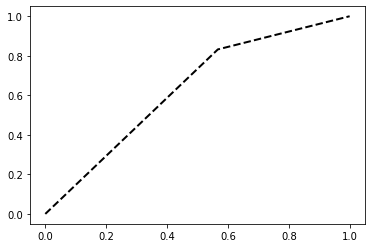

In [25]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

label_ = ([0 if x == 0 else 1 for x in total_label_lt])
predict_ = ([0 if x == 0 else 1 for x in total_predict_lt])
roc_auc_score(label_, predict_)

fpr, tpr, thersholds = roc_curve(label_, predict_, drop_intermediate = False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

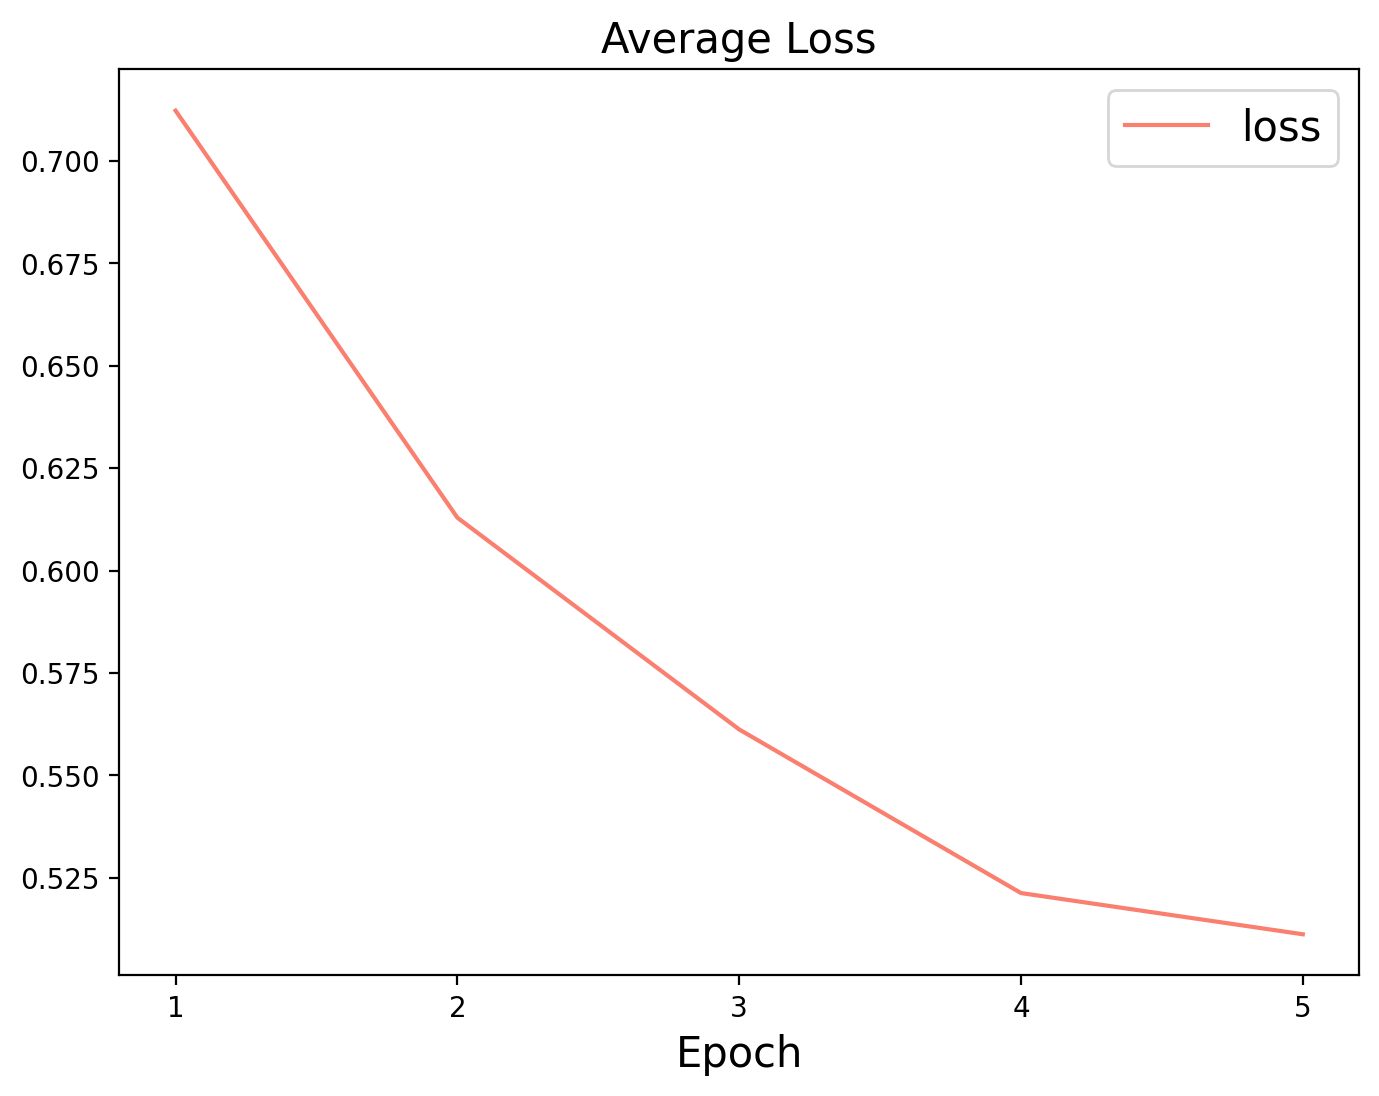

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6), dpi = 200)
plt.plot([1,2,3,4,5],[0.7123124,0.6129424,0.56123949,0.5212934,0.5112344], label = 'loss', color = '#FA7F6F')
plt.legend(fontsize=15)
plt.title('Average Loss', fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.xticks([1,2,3,4,5])
plt.savefig("loss.png")


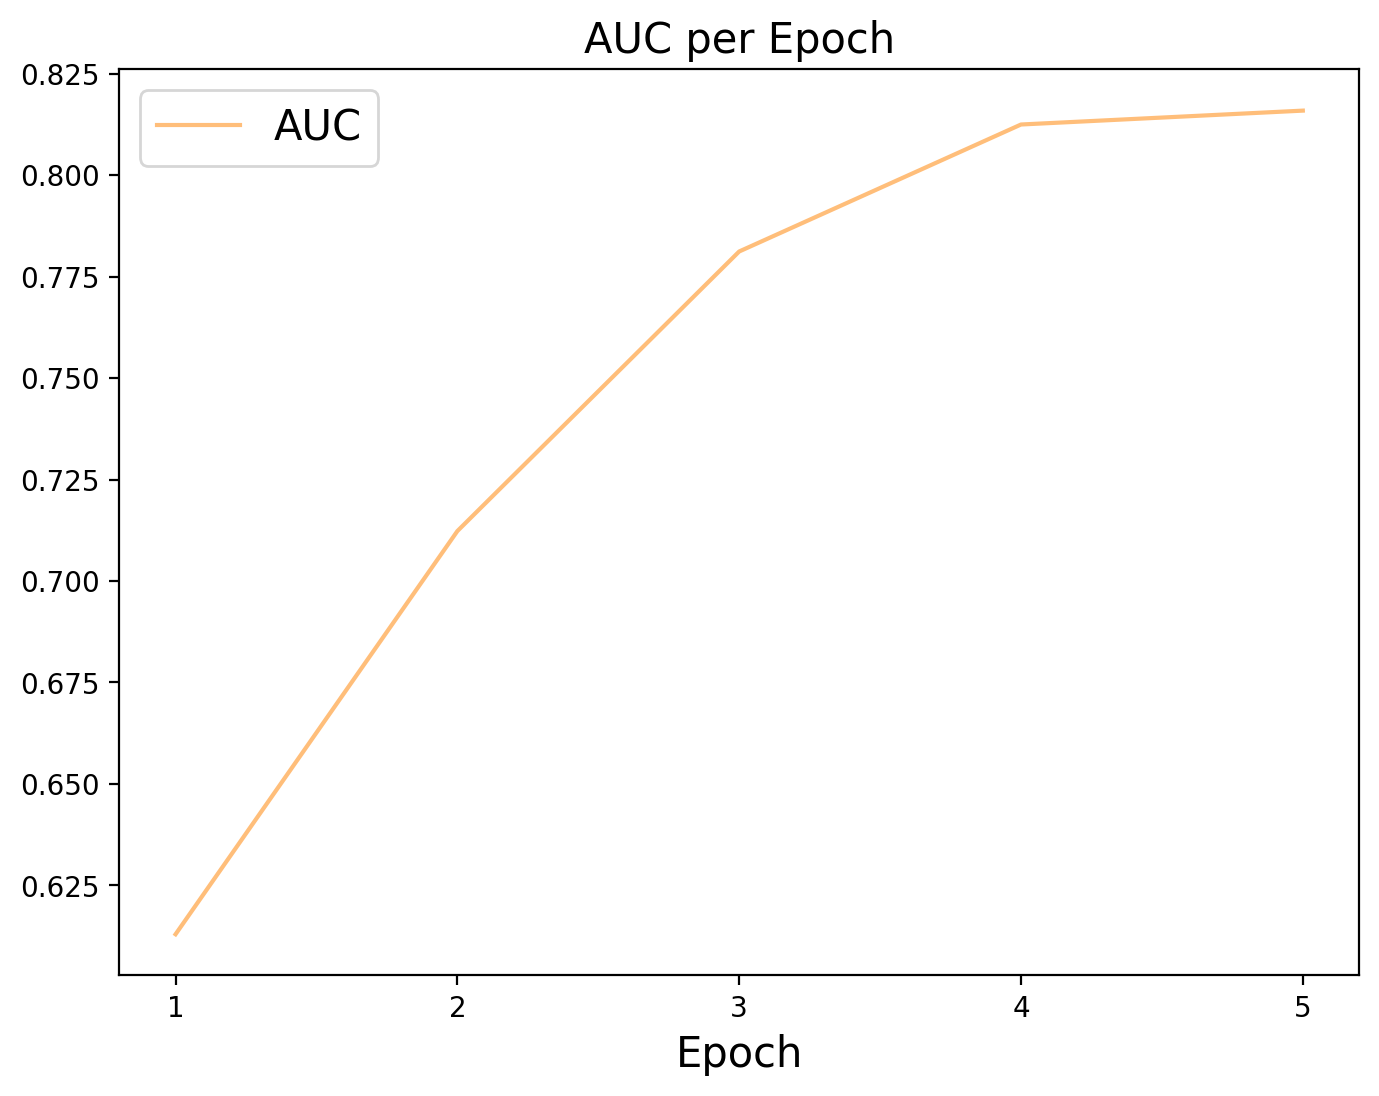

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6), dpi = 200)
plt.plot([1,2,3,4,5],[0.612942,0.712304,0.78120324,0.8124942,0.81591442], label = 'train set AUC', color = '#FFBE7A')
plt.legend(fontsize=15)
plt.title('AUC per Epoch', fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.xticks([1,2,3,4,5])
plt.savefig("loss.png")


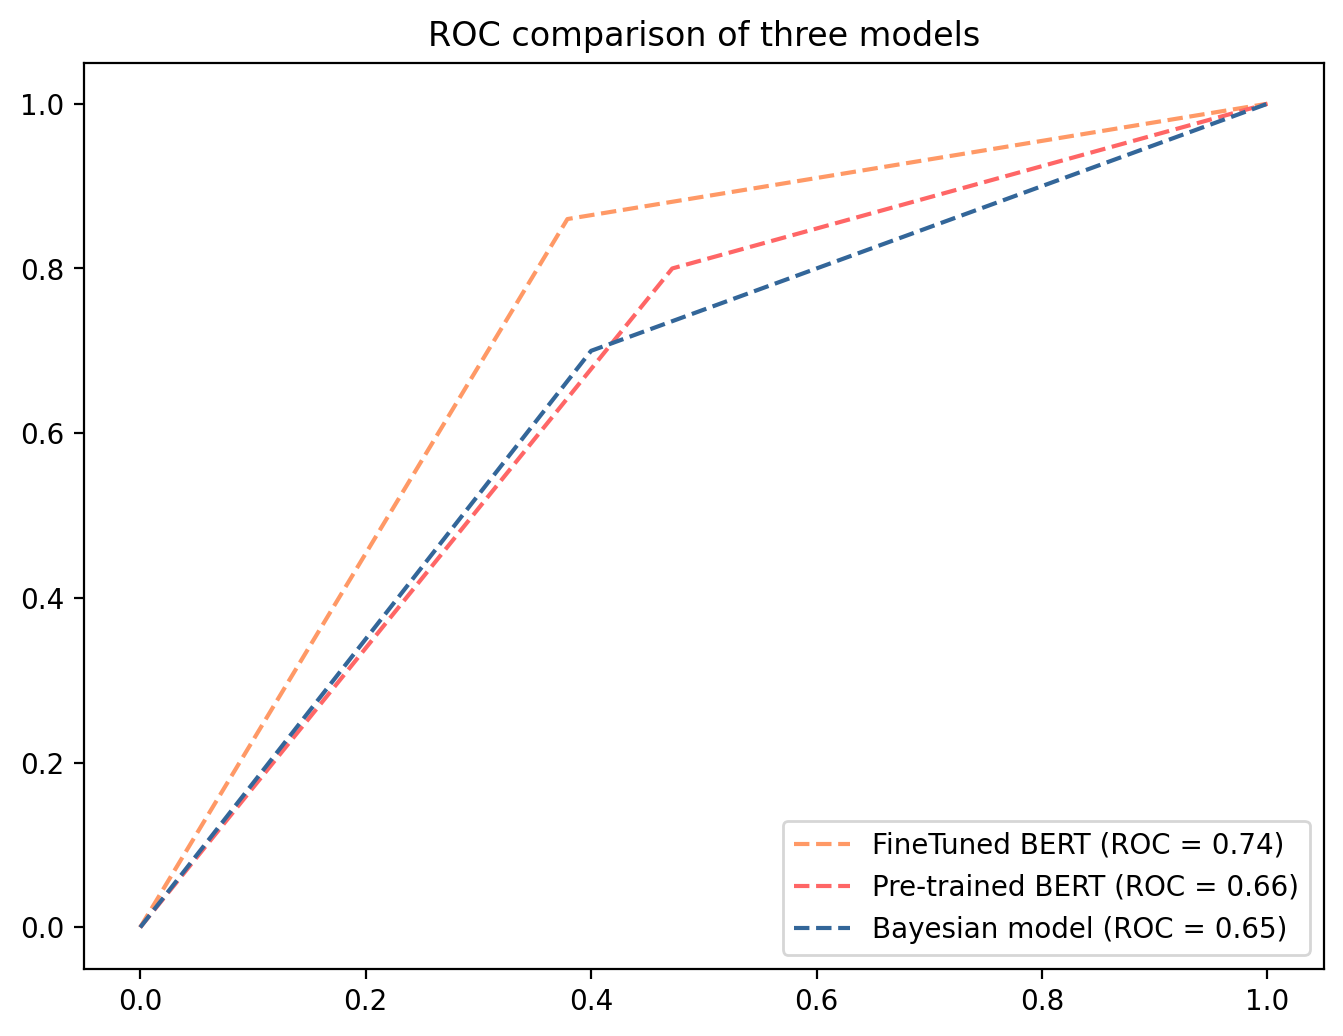

In [54]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (8,6), dpi = 200)
plt.plot(fpr, tpr, 'k--', label='FineTuned BERT (ROC = {0:.2f})'.format(auc(fpr, tpr)),color = '#FF9966')
plt.plot(fpr1, tpr1, 'k--', label='Pre-trained BERT (ROC = {0:.2f})'.format(auc(fpr1, tpr1)), color = '#FF6666')
plt.plot(fpr2, tpr2, 'k--', label='Bayesian model (ROC = {0:.2f})'.format(auc(fpr2, tpr2)), color = '#336699')
plt.legend()
plt.title('ROC comparison of three models')
plt.savefig("ROC.png")

In [39]:
fpr = [0, 0.379,1]
tpr = [0.        , 0.86, 1.        ]

fpr1 = [0, 0.472,1]
tpr1 = [0.        , 0.8, 1.        ]

fpr2 = [0, 0.4,1]
tpr2 = [0.        , 0.7, 1.        ]